In [1]:
import pandas as pd
import json

df_plots = pd.read_csv("plots.csv")
plots = df_plots["plot"].tolist()
high_risk = set(df_plots[df_plots["high_risk"] == 1]["plot"])

with open("constraints.json", "r") as f:
    cfg = json.load(f)

duration = cfg["duration"]

water_per_irrigation = cfg["resources"]["water_per_irrigation"]
base_quota = cfg["resources"]["base_quota"]
vehicles = cfg["resources"]["vehicles"]
battery_capacity = cfg["resources"]["battery_capacity"]
days = cfg["resources"]["days"]

weekly_quota = int(base_quota * 0.7)
daily_quota = weekly_quota // days

In [2]:
def create_actions(day):
    actions = []
    for p in plots:
        prefix = f"{p}_D{day}_"
        actions.append({"name": prefix+"CheckMoisture", "plot": p, "type": "CheckMoisture", "dur": duration["CheckMoisture"], "water": 0})
        actions.append({"name": prefix+"Irrigate", "plot": p, "type": "Irrigate", "dur": duration["Irrigate"], "water": water_per_irrigation})
        actions.append({"name": prefix+"CheckPest", "plot": p, "type": "CheckPest", "dur": duration["CheckPest"], "water": 0})
        actions.append({"name": prefix+"Spray", "plot": p, "type": "Spray", "dur": duration["Spray"], "water": 0})
    return actions

def reset_batteries():
    return {v: battery_capacity for v in vehicles}

def choose_vehicle(battery_levels, act):
    for v in vehicles:
        if battery_levels[v] >= act["dur"]:
            return v
    return None

def recharge(battery_levels):
    for v in battery_levels:
        battery_levels[v] = min(battery_capacity, battery_levels[v] + 3)

In [3]:
def create_goals(day):
    g = set()
    for p in high_risk:
        g.add(f"{p}_D{day}_Irrigated")
        g.add(f"{p}_D{day}_Sprayed")
    return g

In [4]:
def graphplan():
    used_total = 0
    weekly_plan = {}
    for day in range(1, days + 1):
        print("\nDAY", day,"\n")

        actions = create_actions(day)
        goals = create_goals(day)
        remaining_actions = {a["name"]: a for a in actions}
        state = set()

        for p in plots:
            state.add(f"Soil_{p}_D{day}_Unknown")
            state.add(f"Pest_{p}_D{day}_Unknown")

        battery_levels = reset_batteries()
        available_water = min(daily_quota, weekly_quota - used_total)

        day_steps = []

        while goals:
            possible = [a for a in remaining_actions.values()
                        if a["type"] != "Irrigate" or available_water >= a["water"]]
            possible.sort(
                key=lambda x: (x["type"] == "Irrigate", x["plot"] in high_risk),
                reverse=True
            )

            layer = []
            used_in_layer = set()

            for act in possible:
                v = choose_vehicle(battery_levels, act)
                if not v or v in used_in_layer:
                    continue
                used_in_layer.add(v)
                battery_levels[v] -= act["dur"]
                available_water -= act["water"]
                used_total += act["water"]

                print(f"Action: {act['name']}  Vehicle: {v}  Duration: {act['dur']}  BatteryLeft: {battery_levels[v]}")

                if act["type"] == "Irrigate":
                    state.add(f"{act['plot']}_D{day}_Irrigated")
                    goals.discard(f"{act['plot']}_D{day}_Irrigated")

                if act["type"] == "Spray":
                    state.add(f"{act['plot']}_D{day}_Sprayed")
                    goals.discard(f"{act['plot']}_D{day}_Sprayed")

                if act["type"] == "CheckMoisture":
                    state.add(f"Soil_{act['plot']}_D{day}_Checked")

                if act["type"] == "CheckPest":
                    state.add(f"Pest_{act['plot']}_D{day}_Checked")

                layer.append(act["name"])
                del remaining_actions[act["name"]]
            if not layer:
                break
            recharge(battery_levels)
            day_steps.append(layer)
        weekly_plan[day] = day_steps

    return weekly_plan

plan = graphplan()


DAY 1 

Action: P3_D1_Irrigate  Vehicle: Drone1  Duration: 15  BatteryLeft: 7
Action: P7_D1_Irrigate  Vehicle: Drone2  Duration: 15  BatteryLeft: 7
Action: P15_D1_Irrigate  Vehicle: AGV  Duration: 15  BatteryLeft: 7
Action: P3_D1_CheckMoisture  Vehicle: Drone1  Duration: 3  BatteryLeft: 7
Action: P3_D1_CheckPest  Vehicle: Drone1  Duration: 3  BatteryLeft: 7
Action: P22_D1_Irrigate  Vehicle: Drone2  Duration: 15  BatteryLeft: 1
Action: P30_D1_Irrigate  Vehicle: AGV  Duration: 15  BatteryLeft: 1
Action: P3_D1_Spray  Vehicle: Drone1  Duration: 5  BatteryLeft: 5
Action: P7_D1_CheckMoisture  Vehicle: Drone1  Duration: 3  BatteryLeft: 5
Action: P7_D1_CheckPest  Vehicle: Drone1  Duration: 3  BatteryLeft: 5
Action: P7_D1_Spray  Vehicle: Drone1  Duration: 5  BatteryLeft: 3
Action: P15_D1_Spray  Vehicle: Drone2  Duration: 5  BatteryLeft: 5
Action: P15_D1_CheckMoisture  Vehicle: Drone1  Duration: 3  BatteryLeft: 3
Action: P22_D1_Spray  Vehicle: Drone2  Duration: 5  BatteryLeft: 3
Action: P30_D1_

Visualizing Graph Plan Algorithm

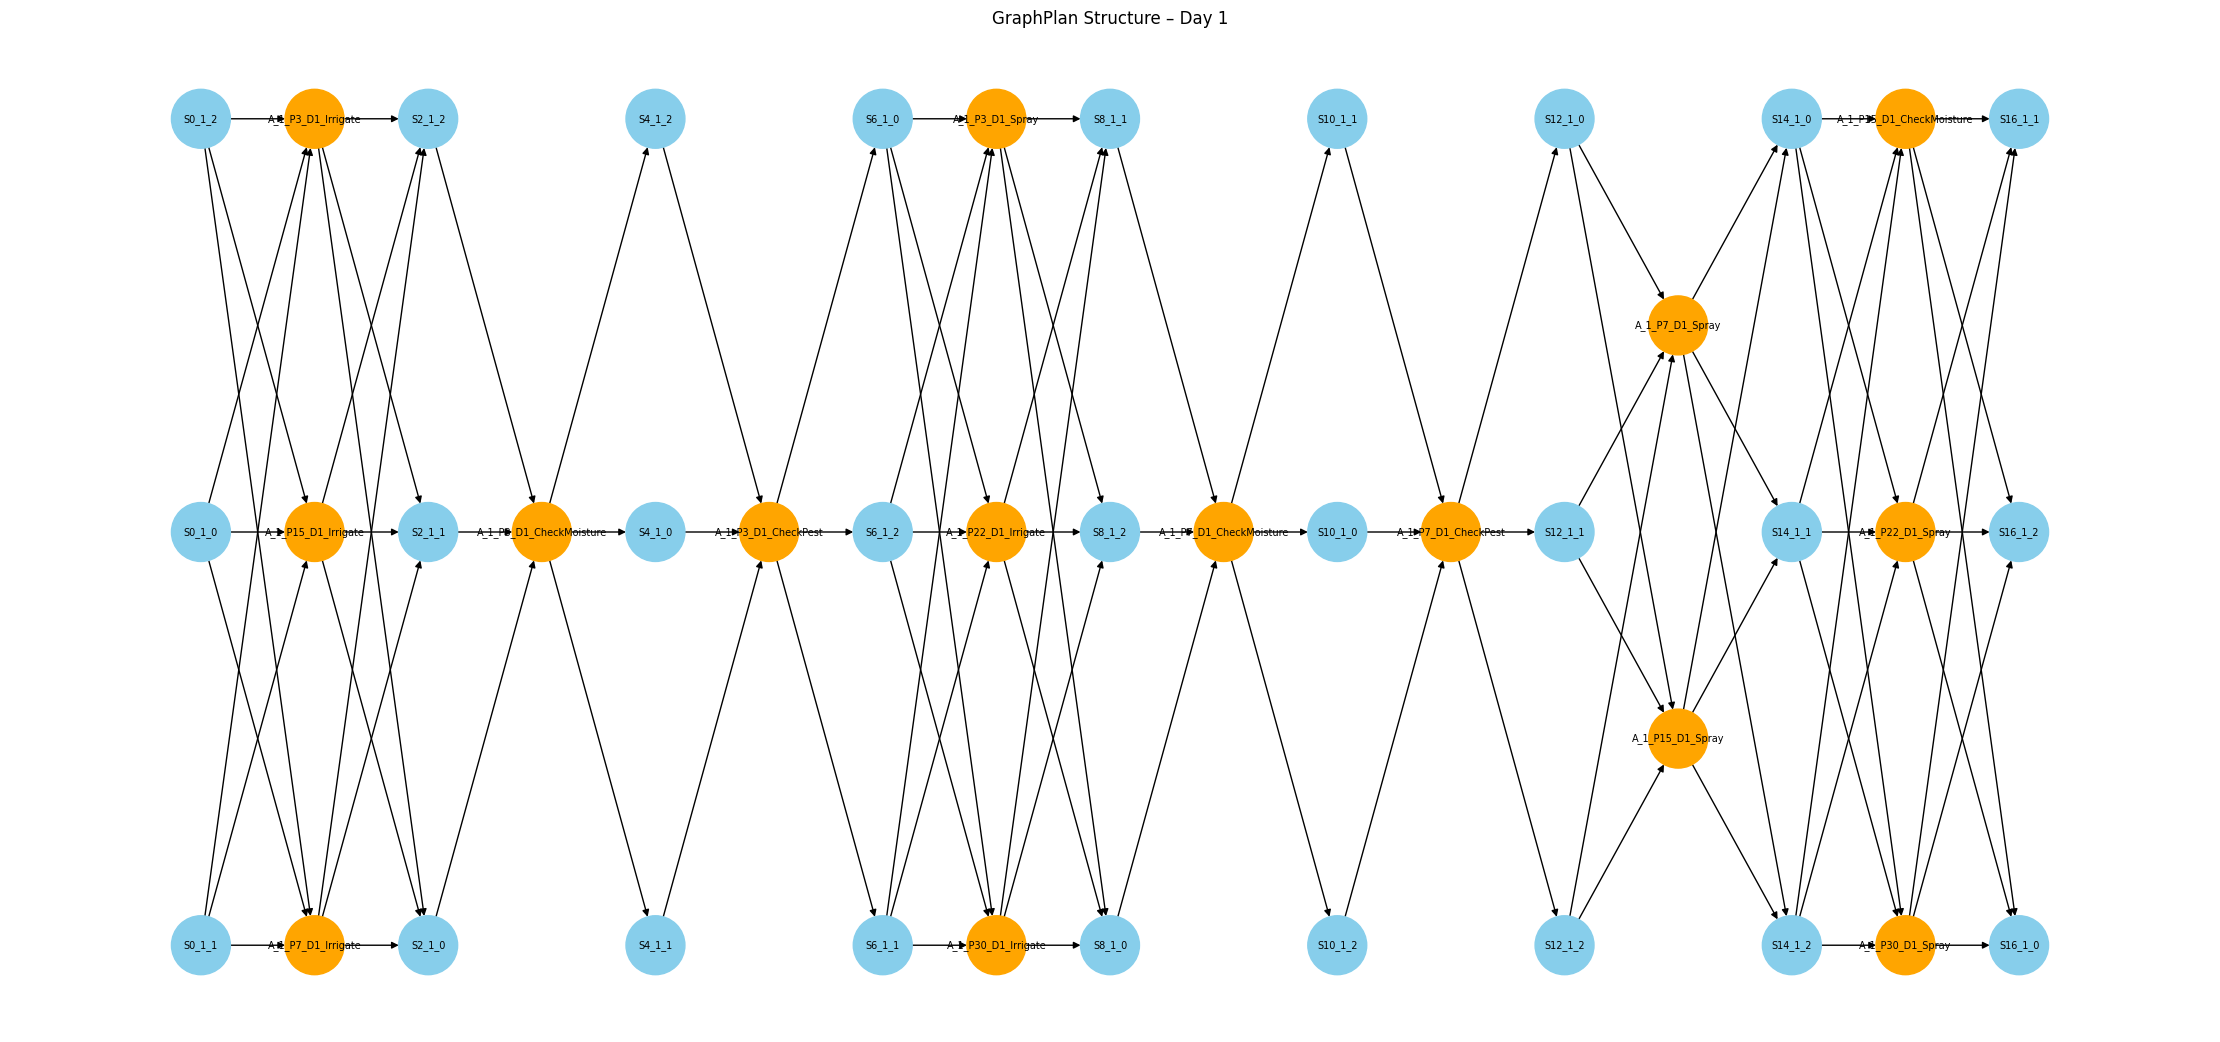

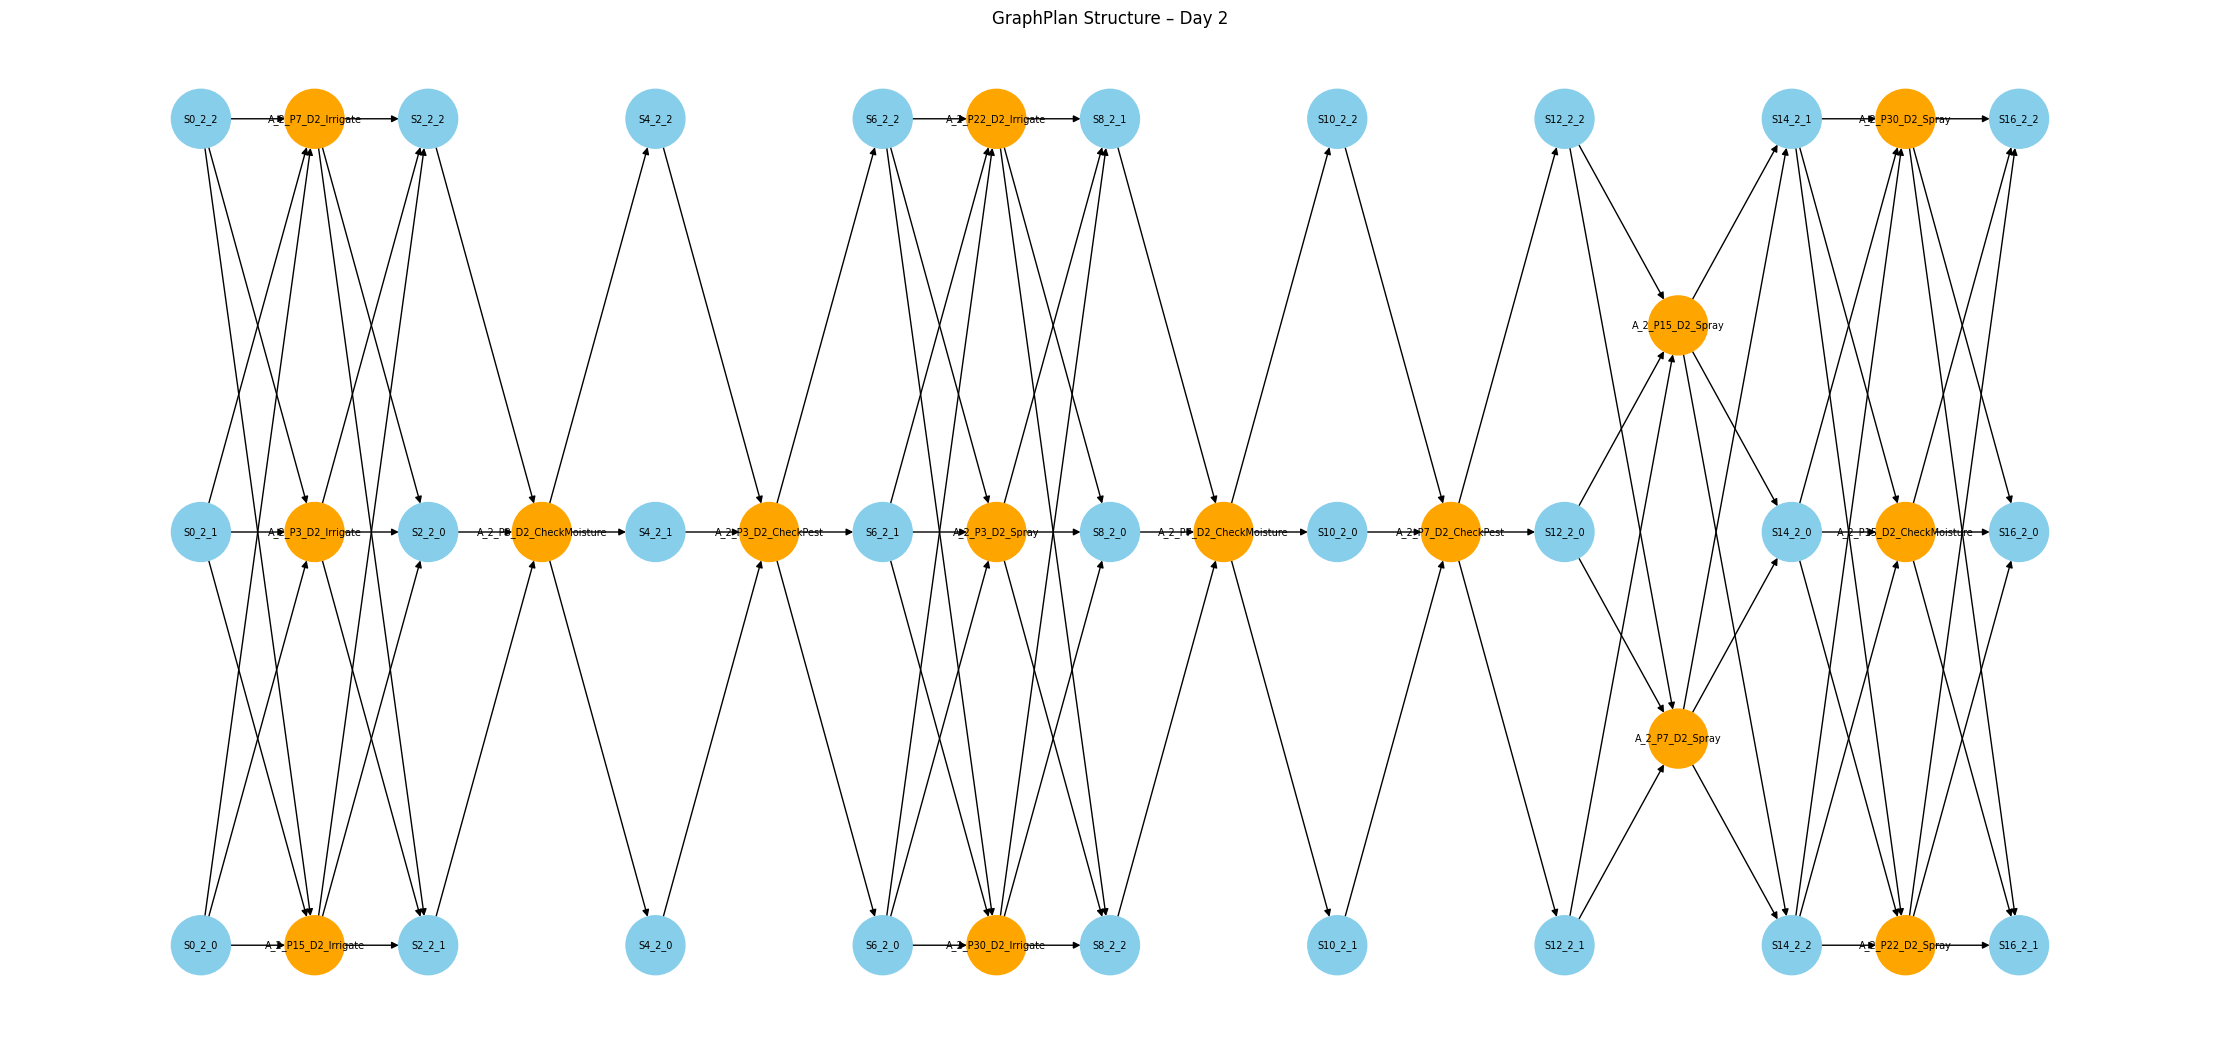

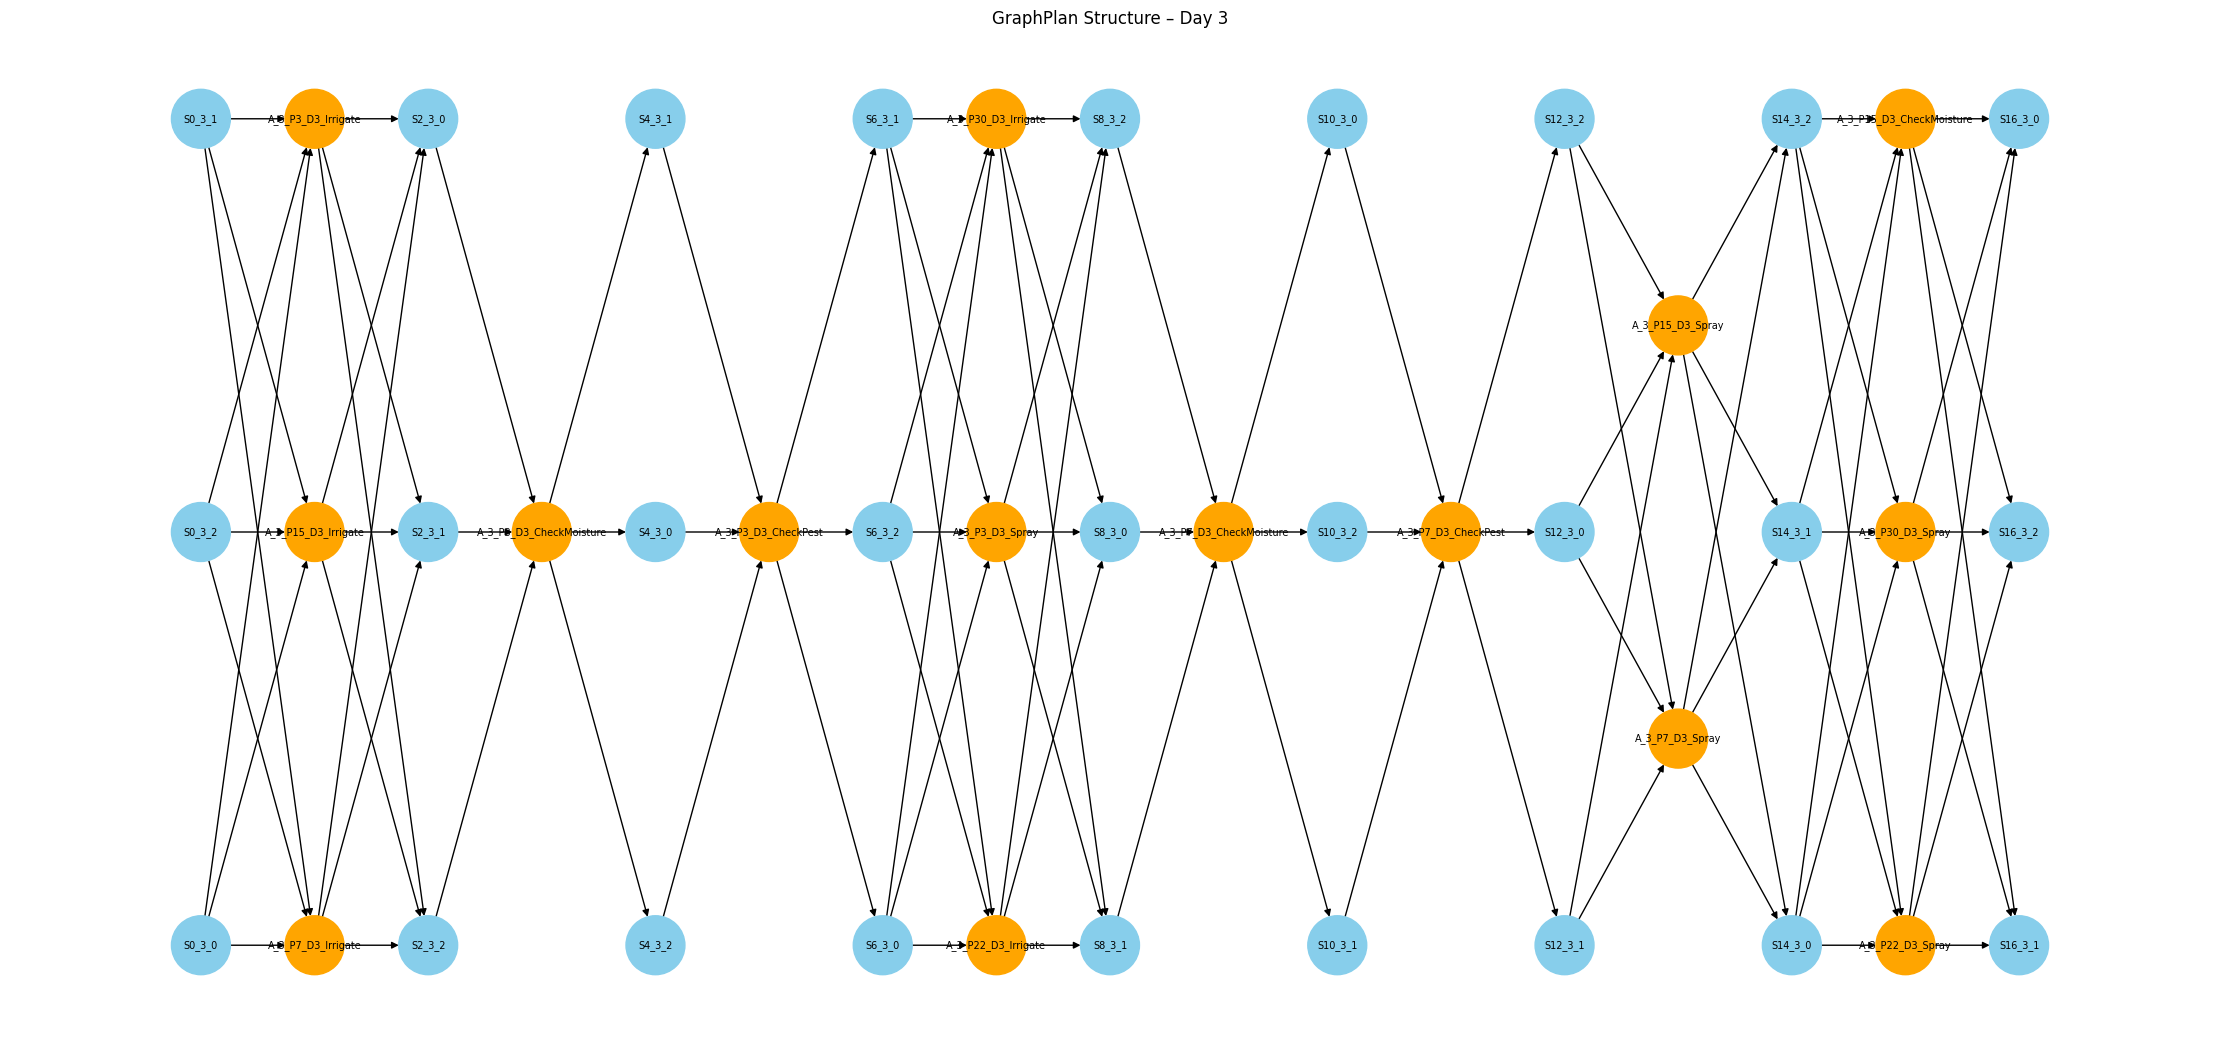

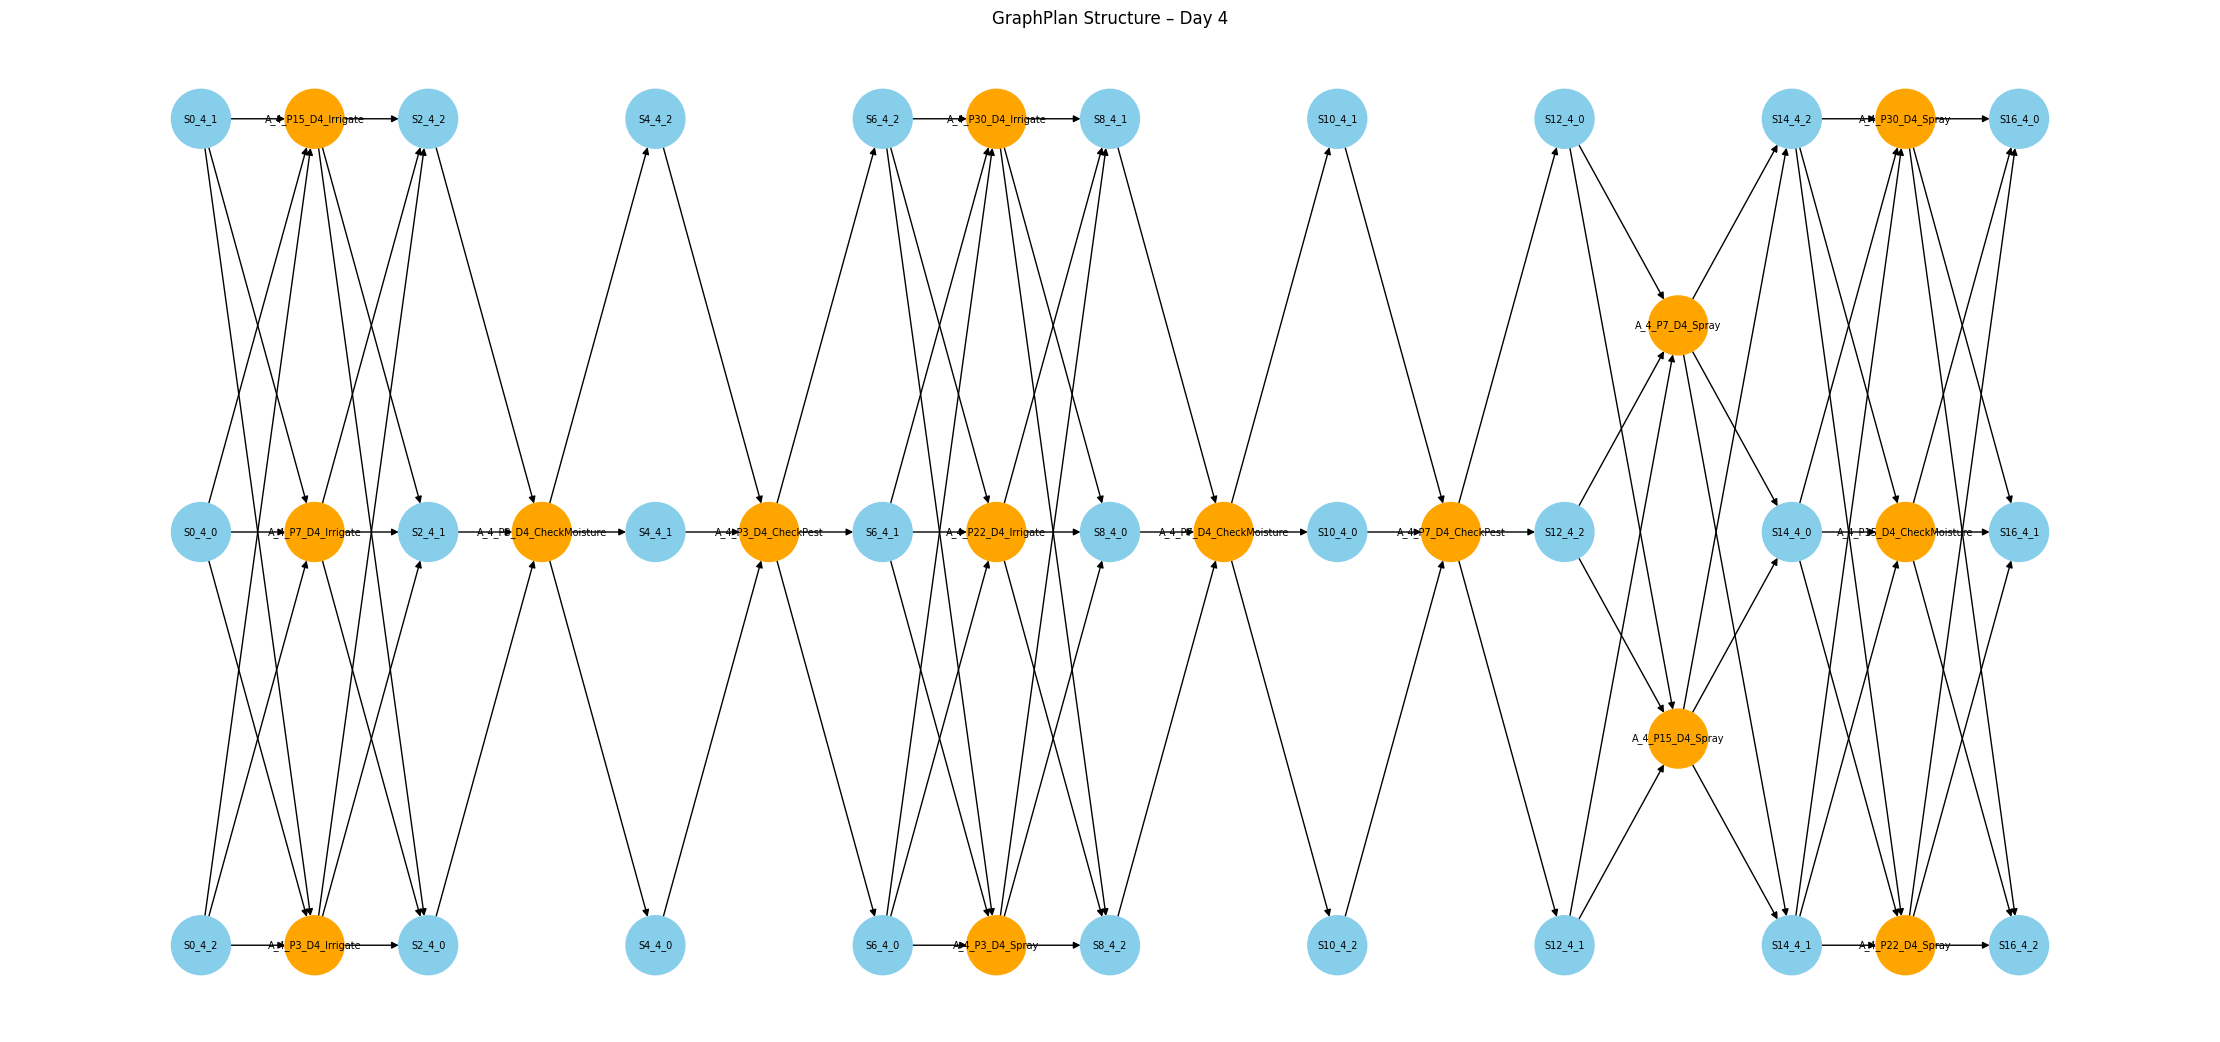

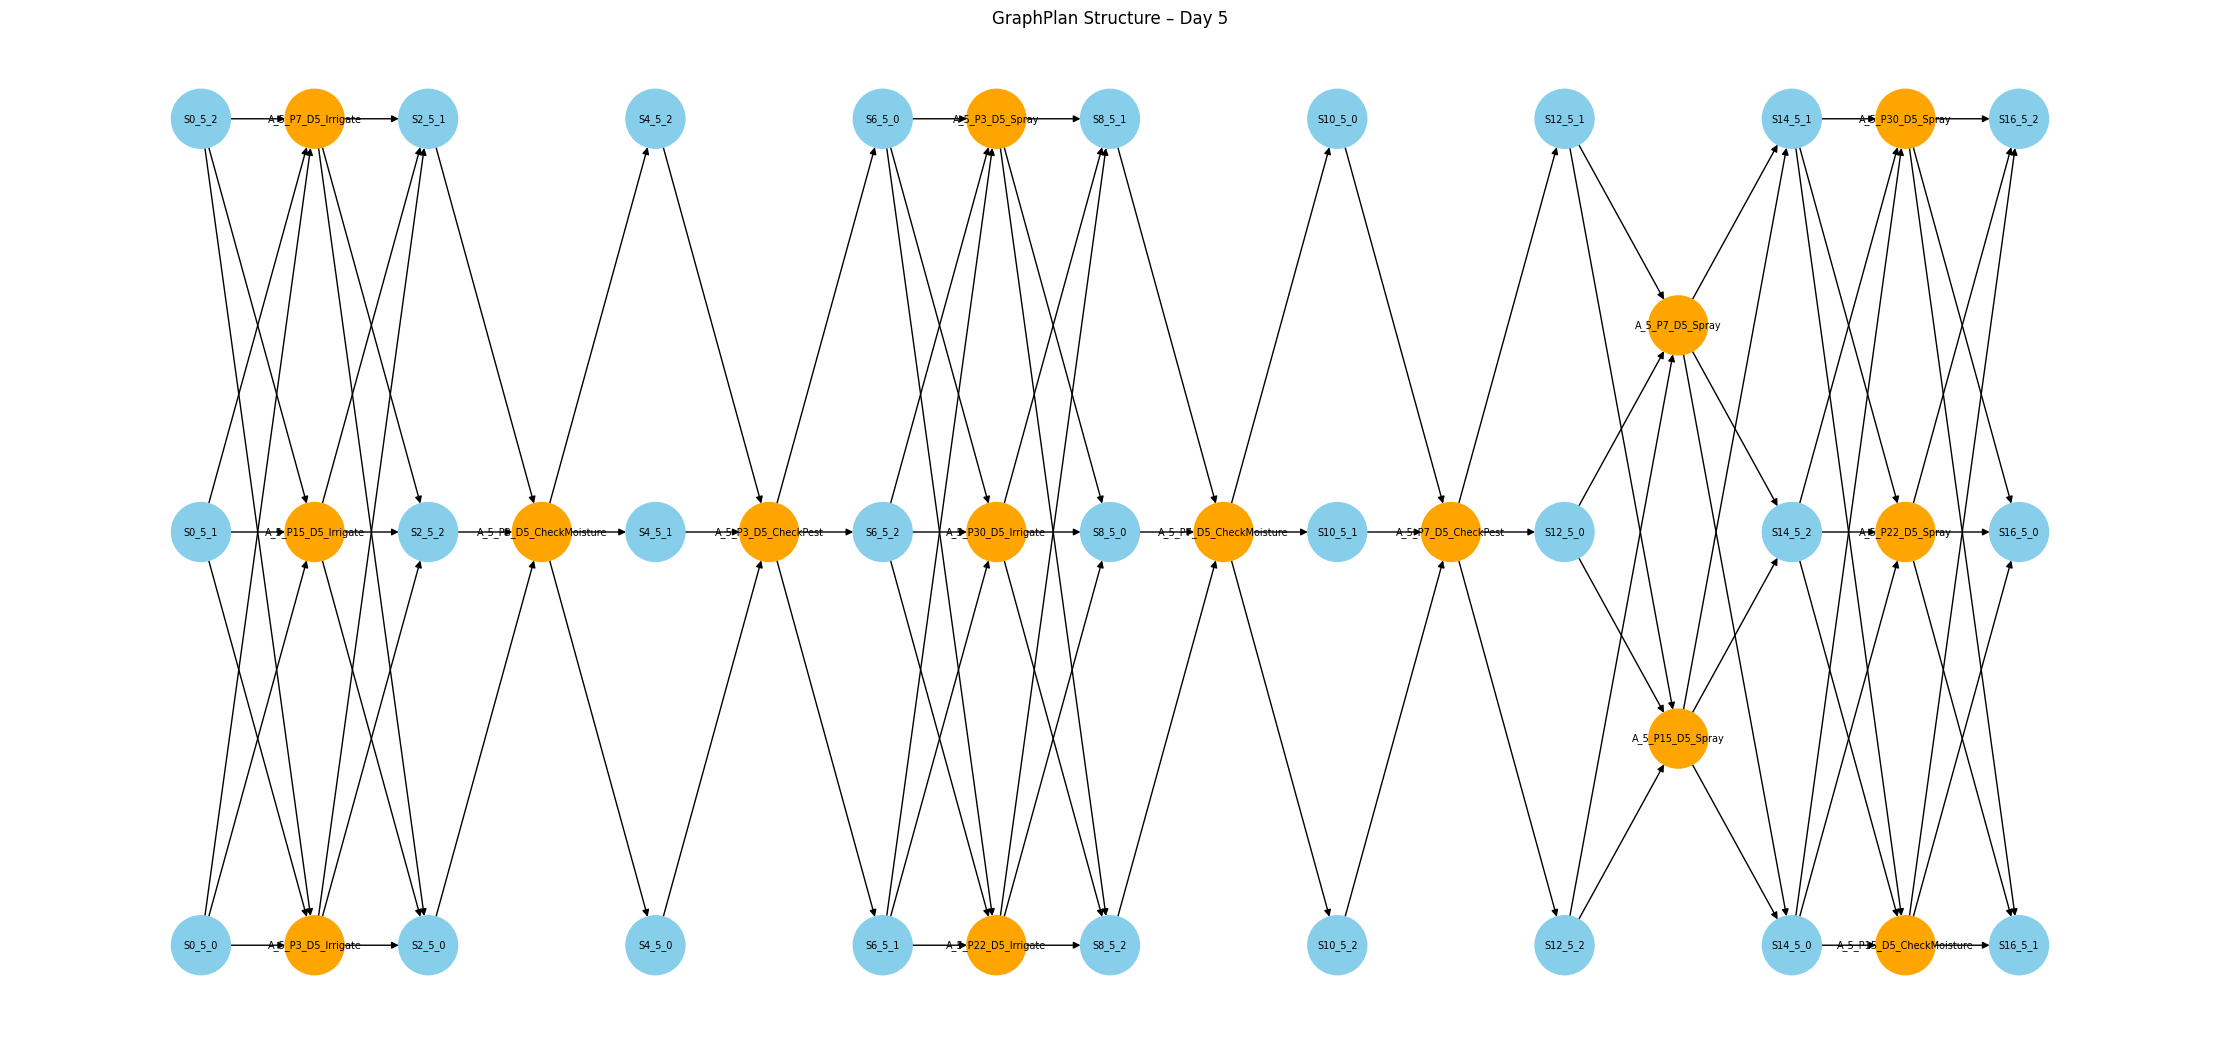

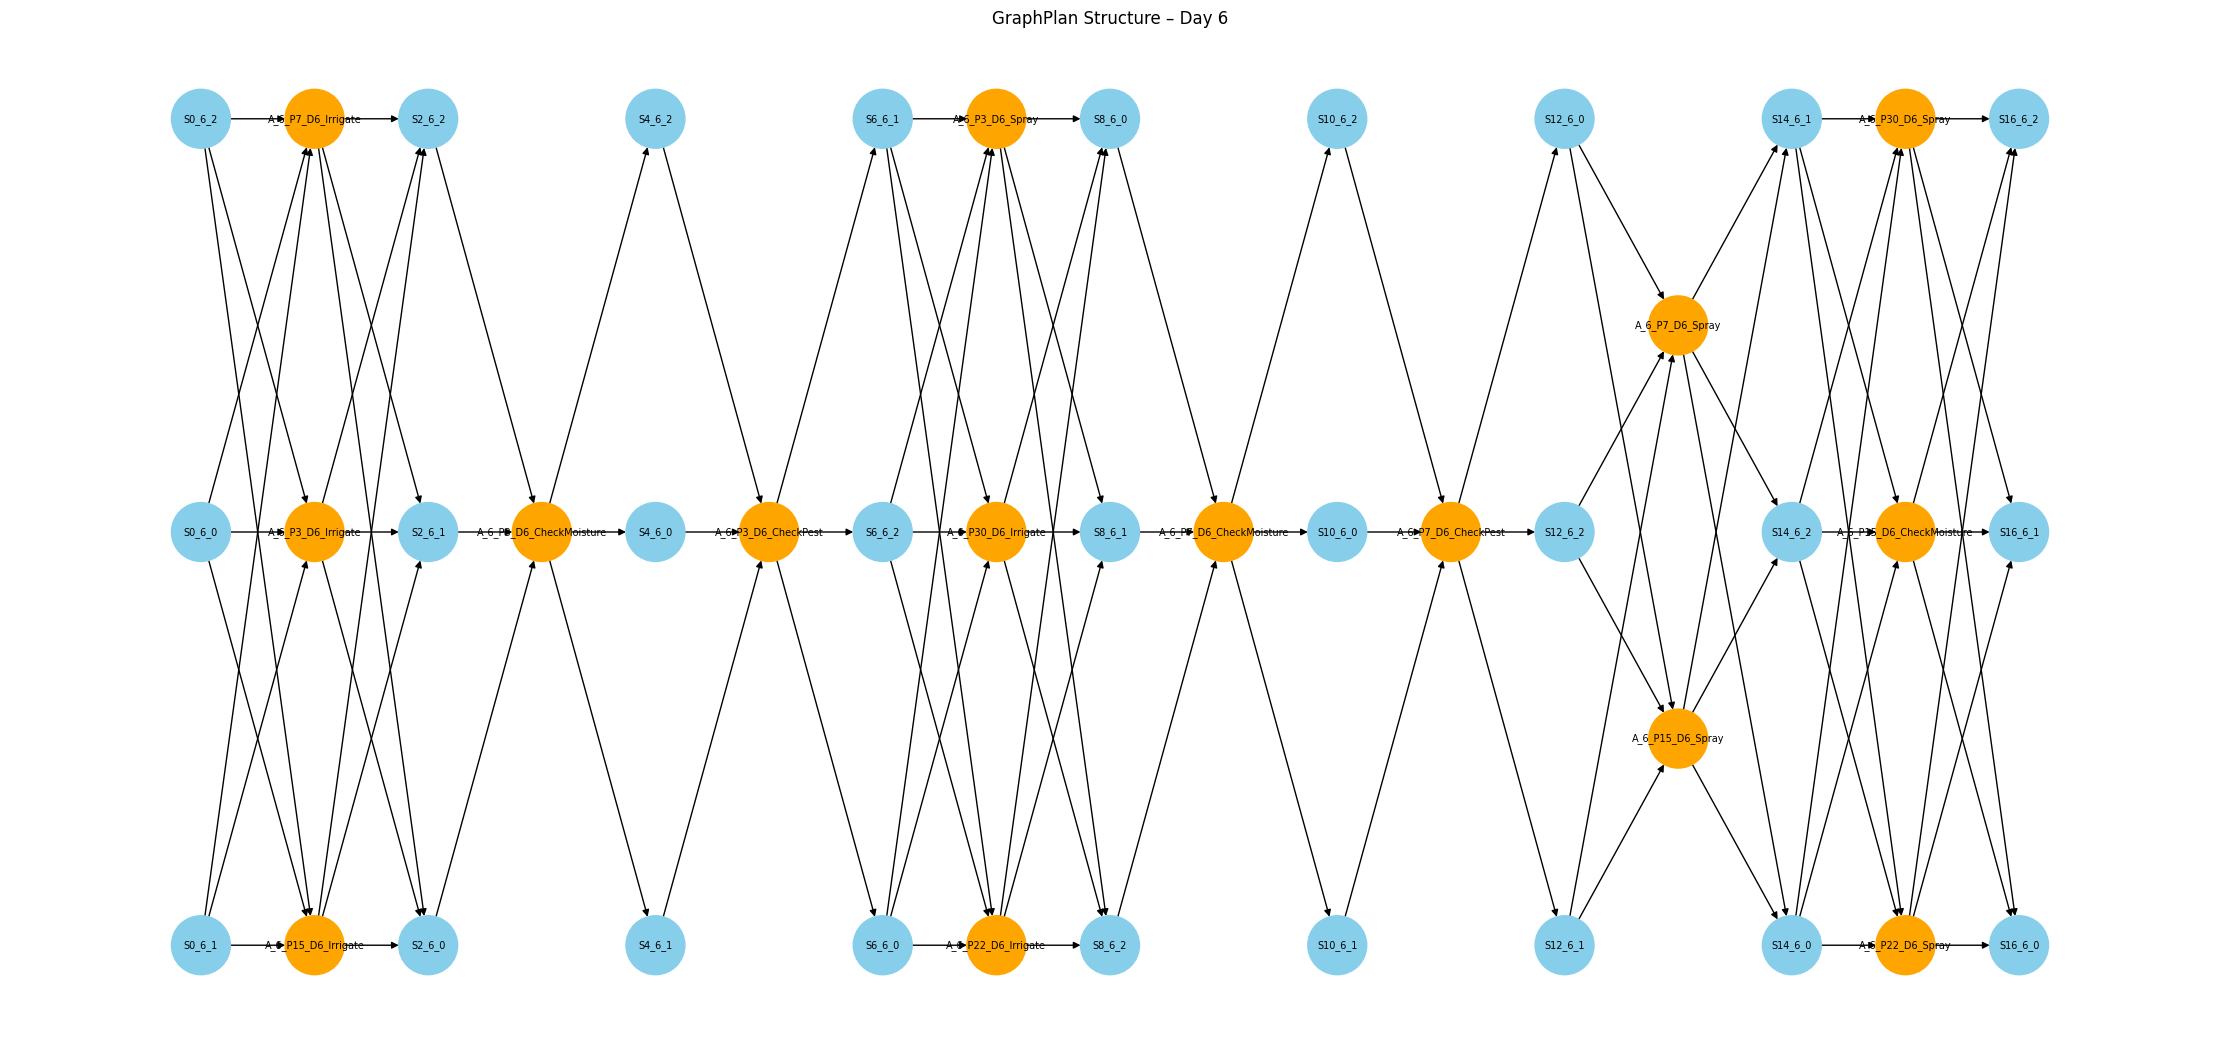

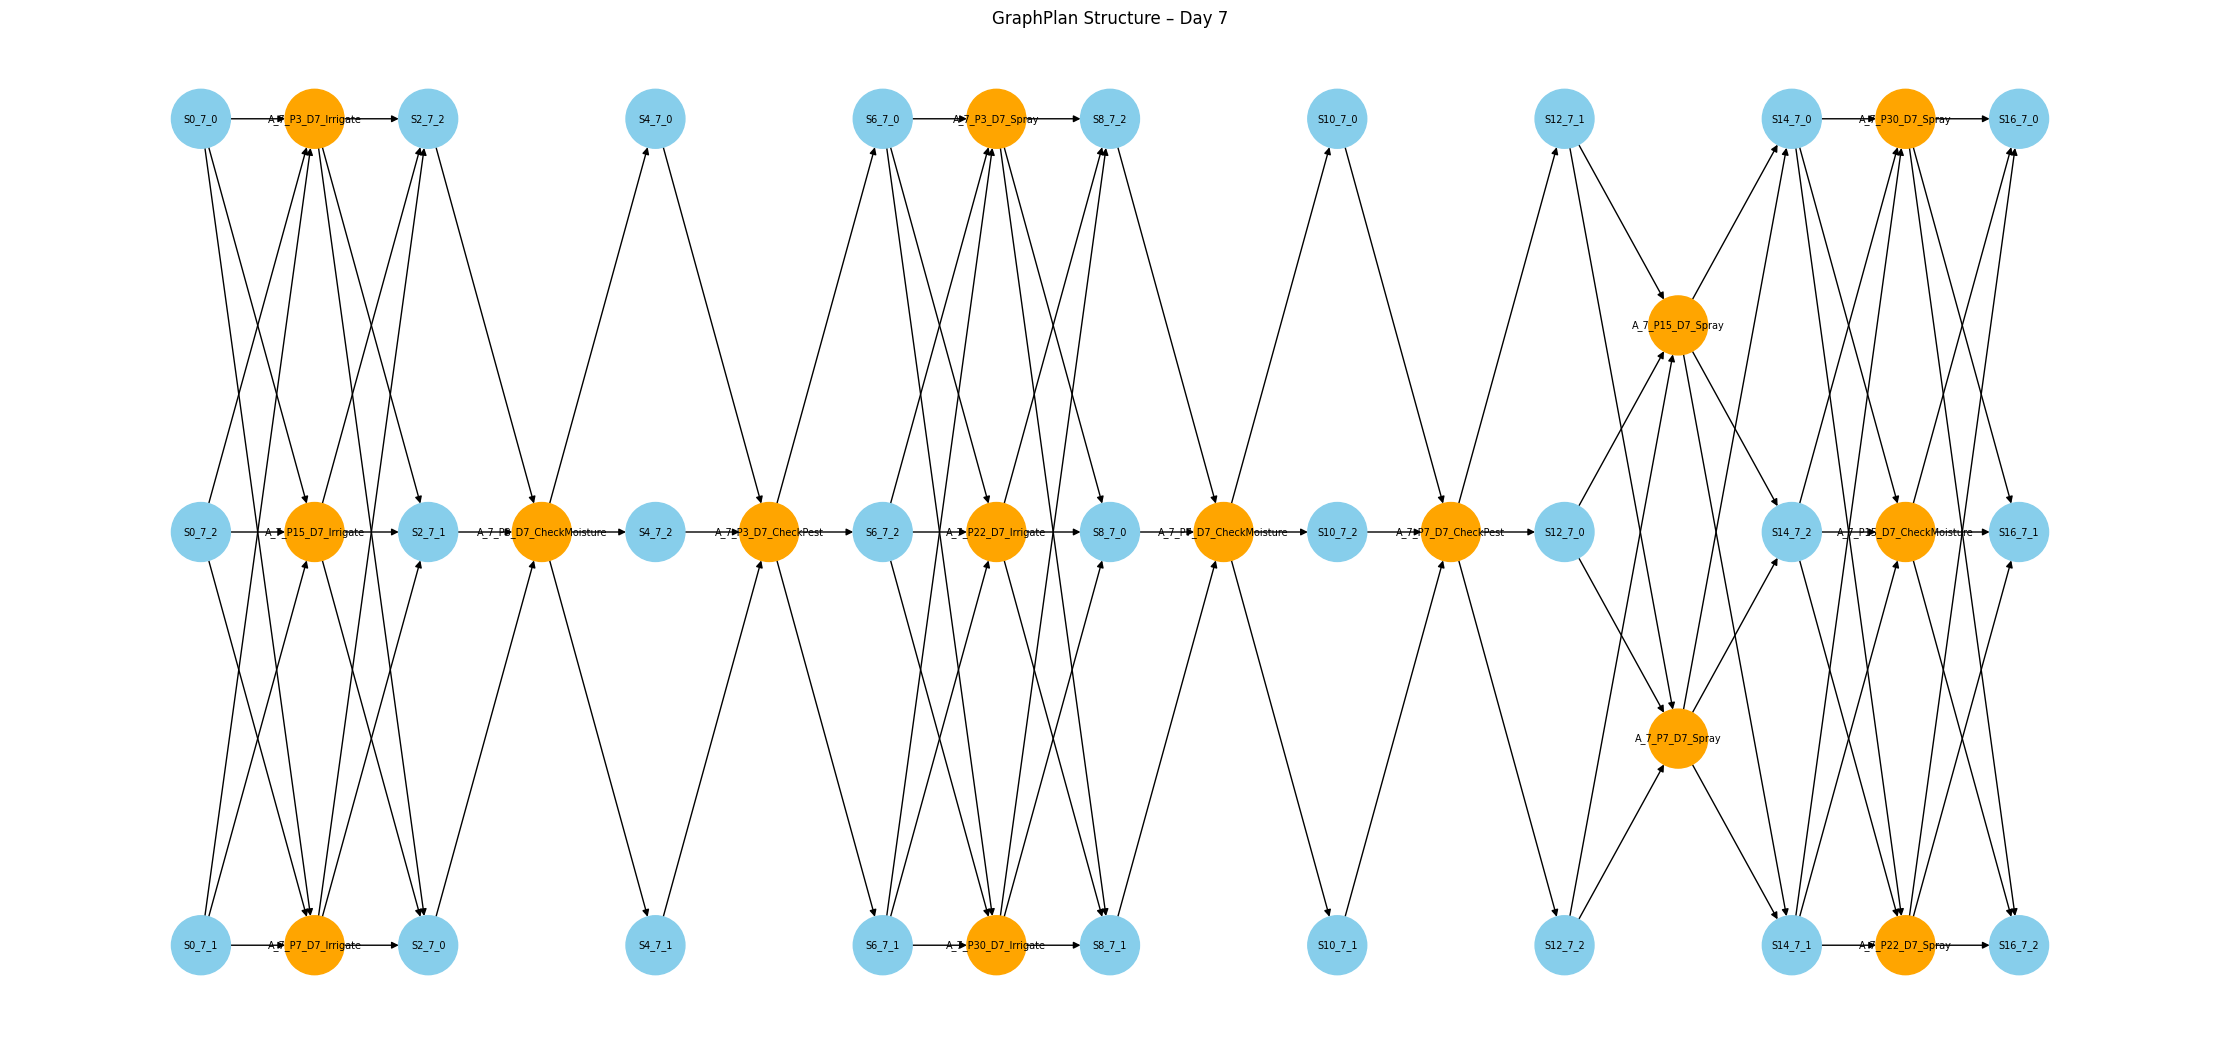

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def build_graphplan_graph(day, layers):
    G = nx.DiGraph()
    level_map = {}

    last_state_nodes = []

    init_state = [f"S0_{day}_{i}" for i in range(3)]
    for n in init_state:
        G.add_node(n, layer=0, color="skyblue")
    last_state_nodes = init_state
    level_map[0] = init_state

    level_index = 1

    for acts in layers:
        action_nodes = []
        for a in acts:
            node = f"A_{day}_{a}"
            G.add_node(node, layer=level_index, color="orange")
            action_nodes.append(node)

            for s in last_state_nodes:
                G.add_edge(s, node)

        level_map[level_index] = action_nodes
        level_index += 1

        next_state = [f"S{level_index}_{day}_{i}" for i in range(3)]
        for s in next_state:
            G.add_node(s, layer=level_index, color="skyblue")
        for a in action_nodes:
            for s in next_state:
                G.add_edge(a, s)

        level_map[level_index] = next_state
        last_state_nodes = next_state
        level_index += 1

    return G

def draw_graphplan(plan):
    for day, layers in plan.items():
        G = build_graphplan_graph(day, layers)

        pos = nx.multipartite_layout(G, subset_key="layer")

        colors = []
        for n in G.nodes():
            if G.nodes[n]["color"] == "orange":
                colors.append("orange")
            else:
                colors.append("skyblue")

        plt.figure(figsize=(22, 10))
        nx.draw(G, pos,
                with_labels=True,
                node_color=colors,
                node_size=1800,
                font_size=7)
        plt.title(f"GraphPlan Structure – Day {day}")
        plt.show()
        plt.close()

draw_graphplan(plan)

Visualizing Planning

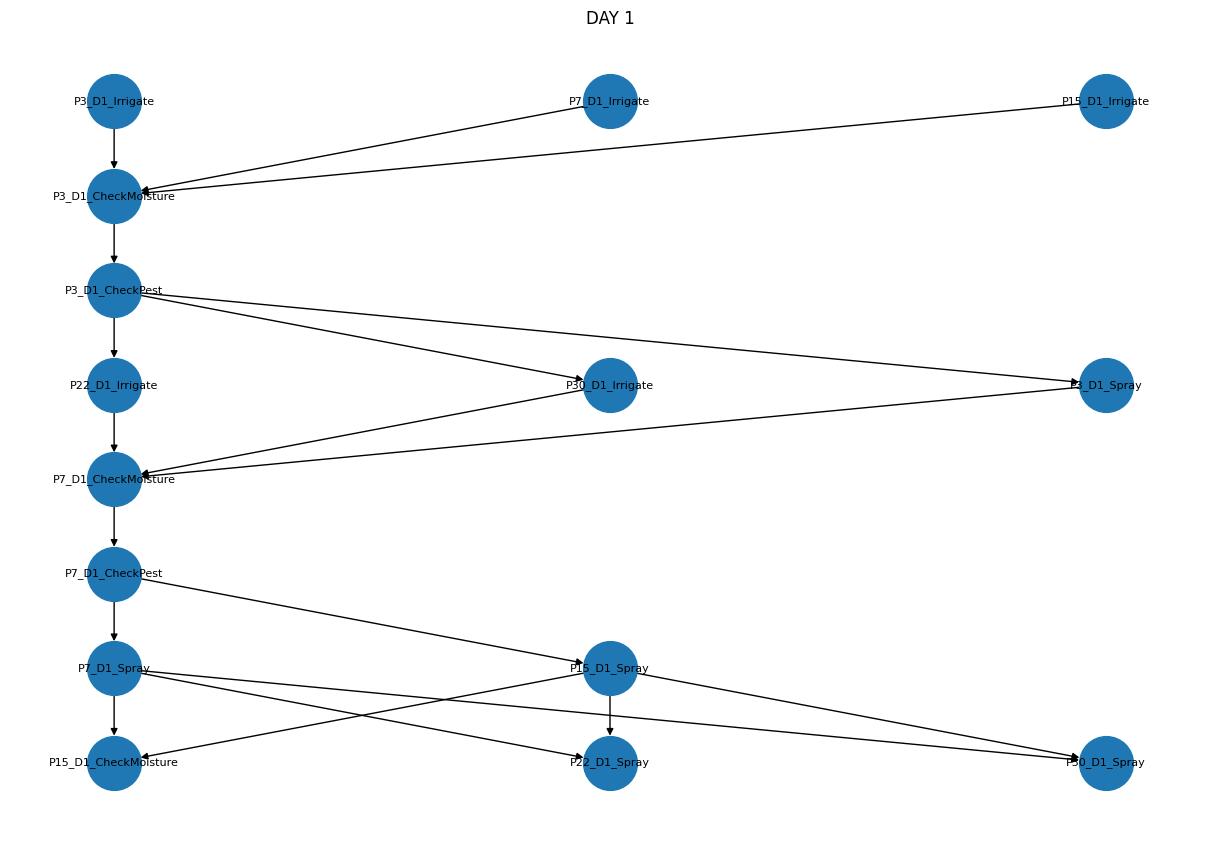

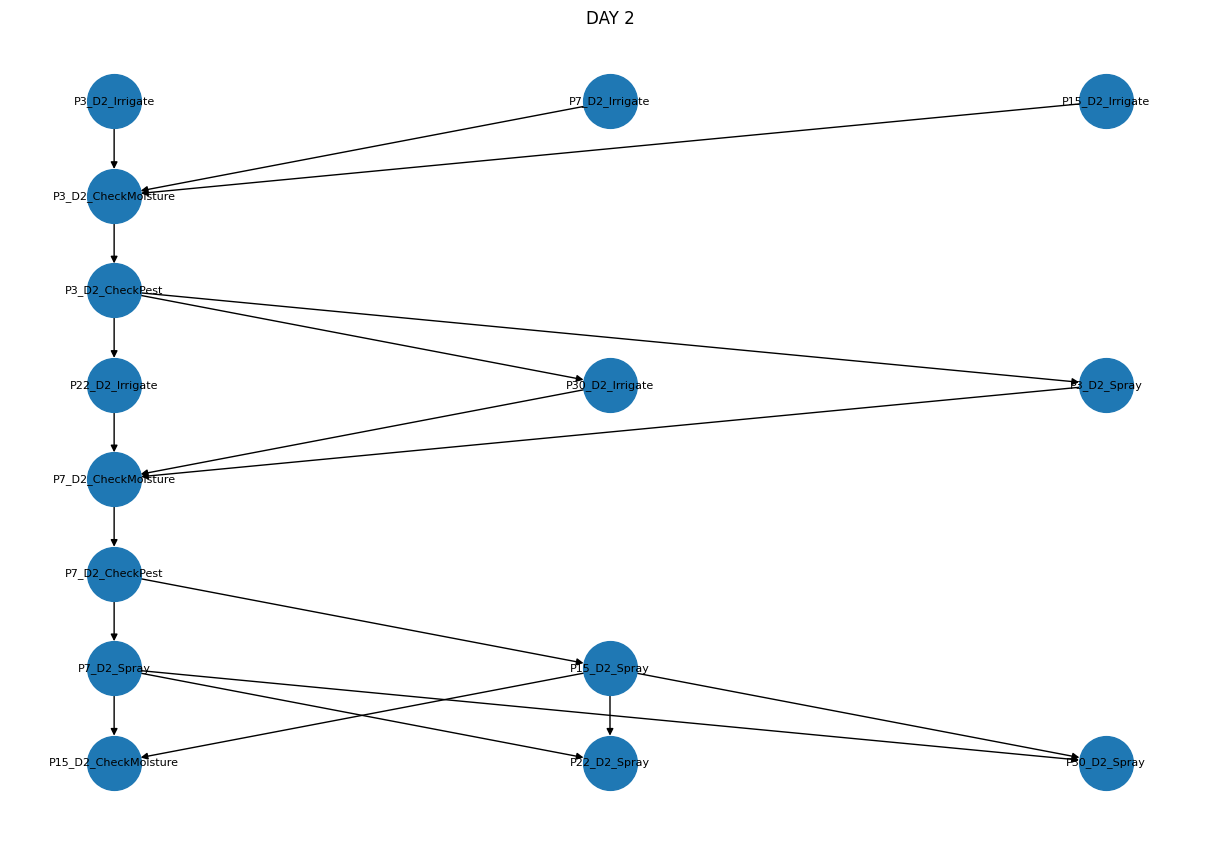

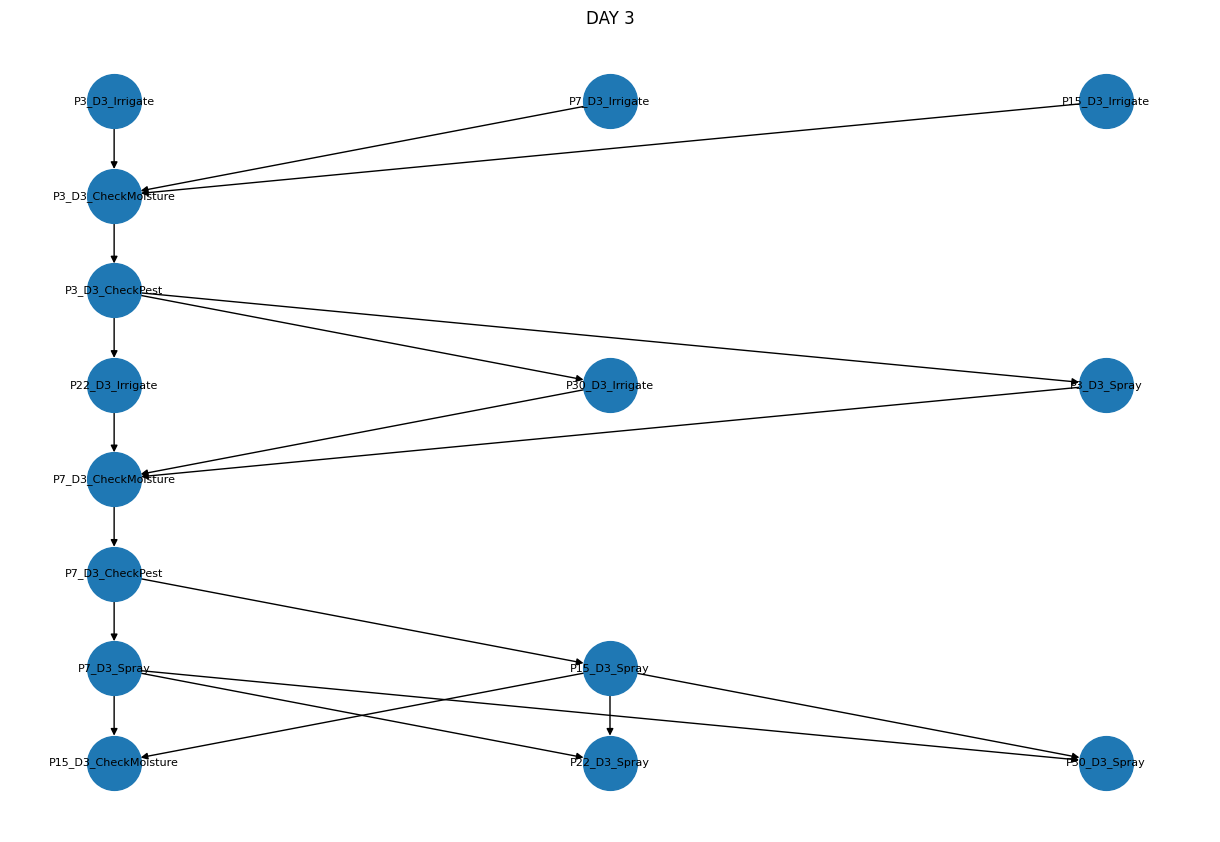

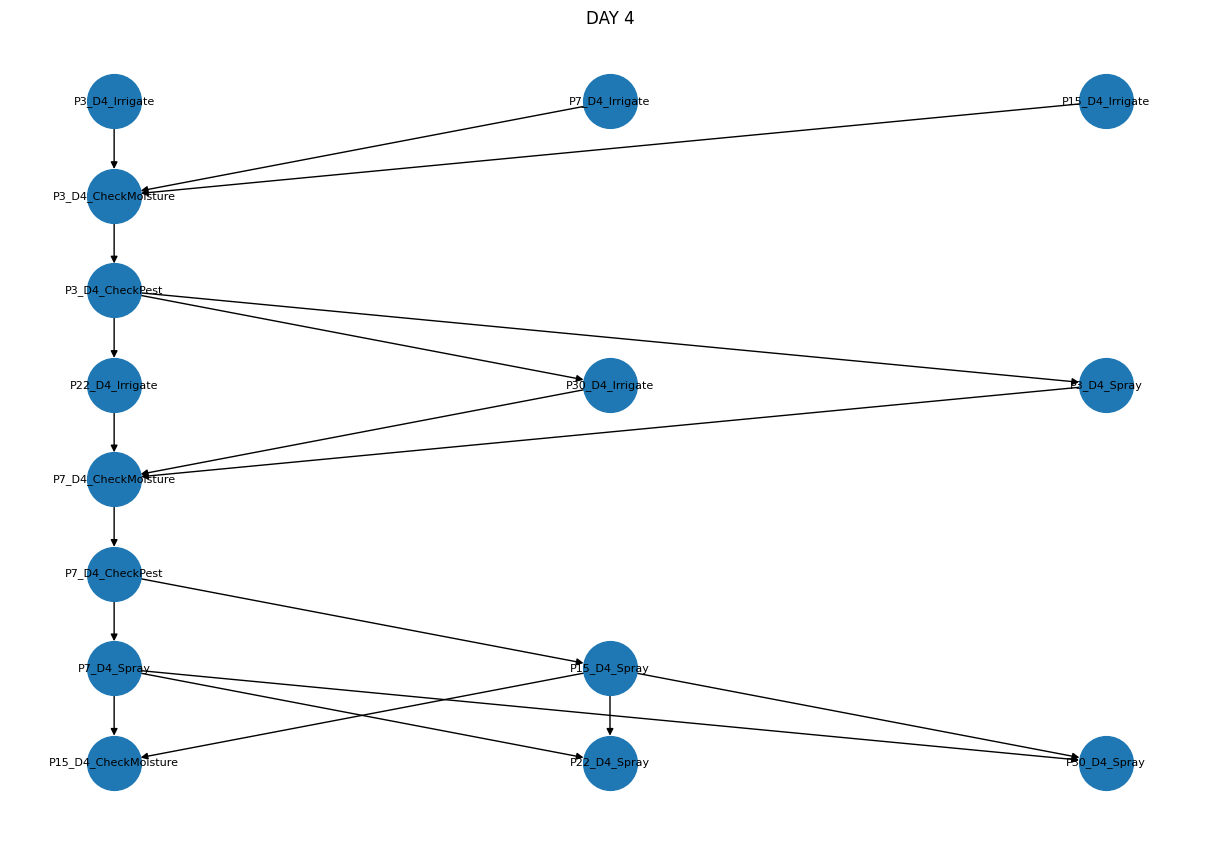

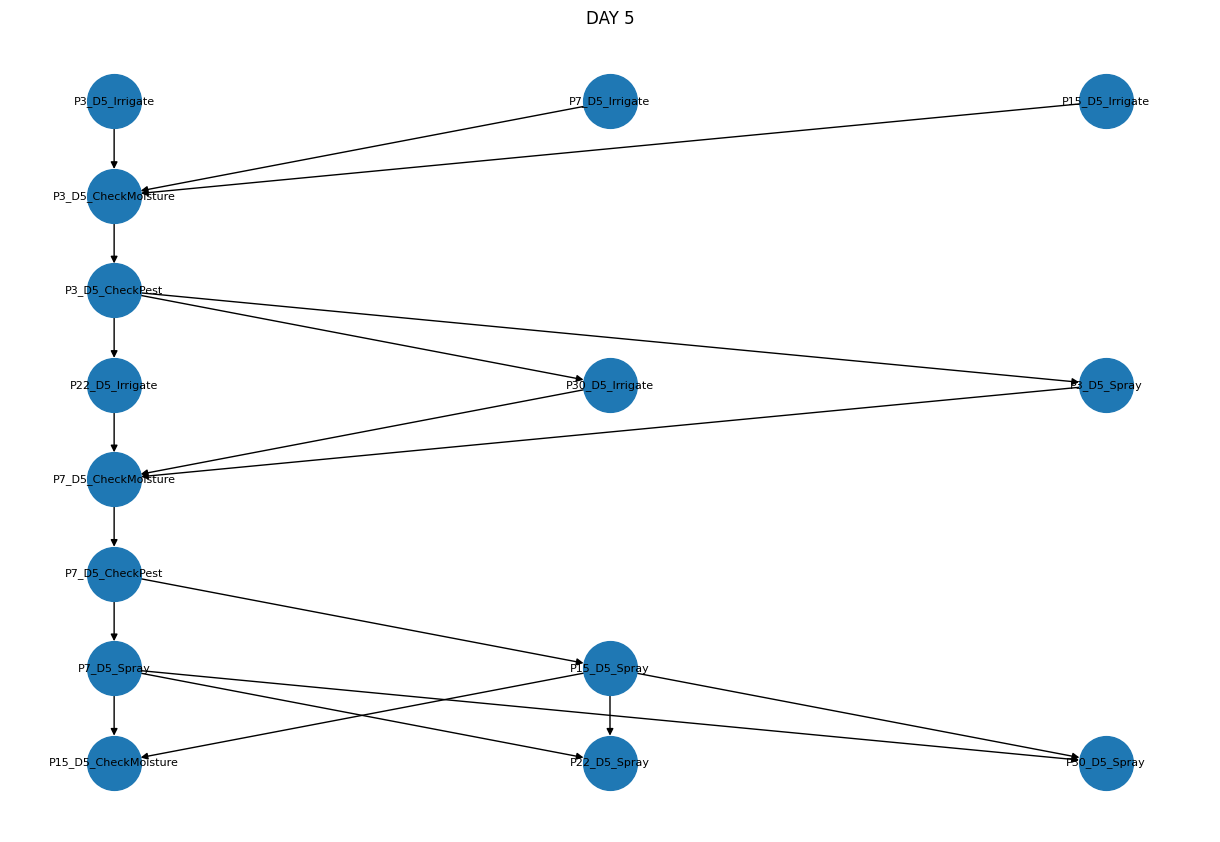

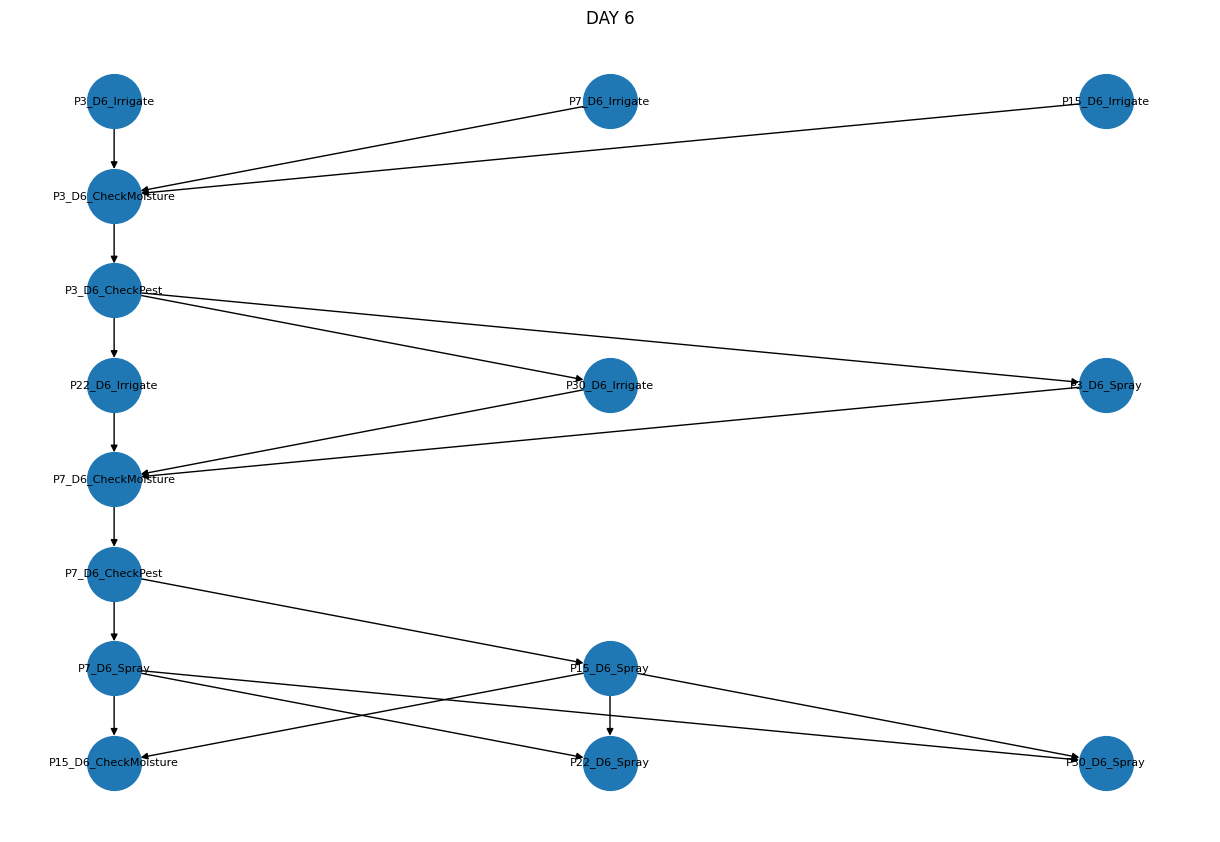

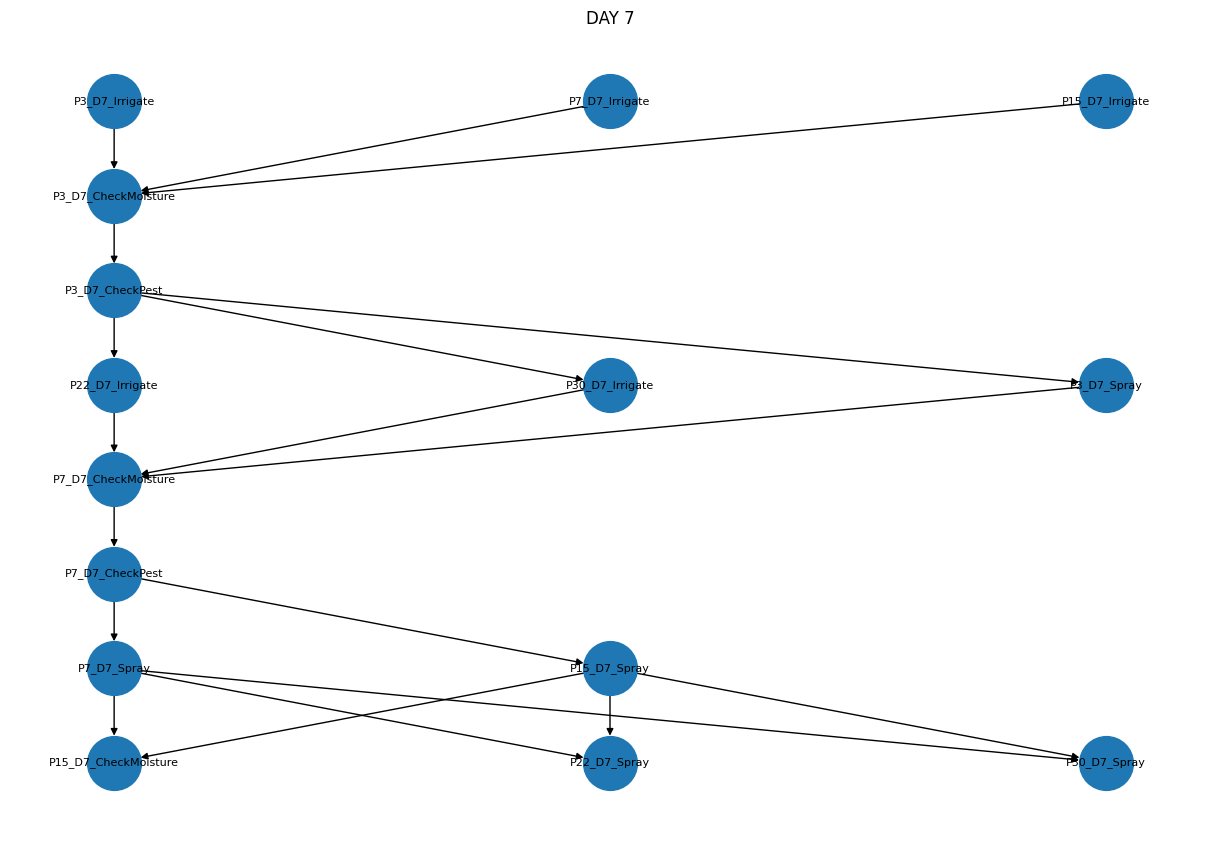

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

for d in plan:
    G = nx.DiGraph()
    steps = plan[d]
    for t, step in enumerate(steps):
        for a in step:
            G.add_node(a, level=t)
        if t > 0:
            for prev in steps[t-1]:
                for curr in step:
                    G.add_edge(prev, curr)

    pos = {}
    for t, step in enumerate(steps):
        for i, a in enumerate(step):
            pos[a] = (i, -t)

    plt.figure(figsize=(12,8))
    nx.draw(G, pos, with_labels=True, node_size=1500, font_size=8)
    plt.title(f"DAY {d}")
    plt.show()